In [1]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error


In [2]:
def transition_process_1d(x, V):
    new_x = x + np.random.normal(0, np.sqrt(V))
    return new_x

def observation_process_1d(x, S):
    new_obs = x + np.random.normal(0, np.sqrt(S))
    return new_obs

def generate_1d(T, V, S):
    X = [np.array(50.0)]
    Y = [observation_process_1d(X[0], S)]

    for t in range(1, T):
        X.append(transition_process_1d(X[-1], V))
        Y.append(observation_process_1d(X[-1], S))

    return np.array(X), np.array(Y)

In [3]:
def create_dataset(data, seq_len):
    sequences = []
    labels = []
    for i in range(len(data) - seq_len):
        seq = data[i:i+seq_len]
        label = data[i+seq_len]
        sequences.append(seq)
        labels.append(label)
    return torch.stack(sequences), torch.stack(labels)

In [4]:
def plot_data(X, Y):
    # Plot data
    fig, ax1 = plt.subplots()

    color = 'tab:red'
    ax1.set_xlabel('Time')
    ax1.set_ylabel('True State', color=color)
    ax1.plot(X, color=color)
    ax1.tick_params(axis='y', labelcolor=color)

    ax2 = ax1.twinx()  
    color = 'tab:blue'
    ax2.set_ylabel('Observations', color=color)  
    ax2.plot(Y, color=color)
    ax2.tick_params(axis='y', labelcolor=color)

    fig.tight_layout()  
    plt.show()

In [5]:
class RNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(RNN, self).__init__()
        self.rnn = nn.RNN(input_size, hidden_size, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        out, h_n = self.rnn(x) # h_n be the hidden states
        out = self.fc(out[:, -1, :])
        return out, h_n

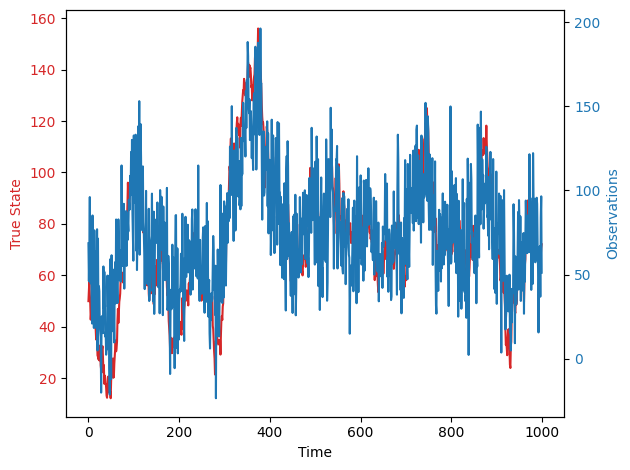

In [6]:
# Generate data
T = 1000
V = 20
S = 500
X, Y = generate_1d(T, V, S)
plot_data(X, Y)
data = torch.tensor(Y, dtype=torch.float32)

In [7]:
seq_len = 5
sequences, labels = create_dataset(data, seq_len)

# Split the dataset into training, validation, and test sets
train_size = int(0.6 * len(sequences))
val_size = int(0.2 * len(sequences))
test_size = len(sequences) - train_size - val_size

train_sequences, train_labels = sequences[:train_size], labels[:train_size]
val_sequences, val_labels = sequences[train_size:train_size+val_size], labels[train_size:train_size+val_size]
test_sequences, test_labels = sequences[train_size+val_size:], labels[train_size+val_size:]

In [8]:
torch.save(train_labels, 'train_labels.pt')
torch.save(test_labels, 'test_labels.pt')

torch.save(train_sequences, 'raw_train_seqs.pt')
torch.save(test_sequences, 'raw_test_seqs.pt')

Epoch 0/5000, Train loss: 7093.40, Validation loss: 7028.67
Epoch 200/5000, Train loss: 5469.46, Validation loss: 5302.85
Epoch 400/5000, Train loss: 4218.56, Validation loss: 3956.32
Epoch 600/5000, Train loss: 3285.30, Validation loss: 2936.52
Epoch 800/5000, Train loss: 2609.88, Validation loss: 2183.75
Epoch 1000/5000, Train loss: 2139.39, Validation loss: 1645.25
Epoch 1200/5000, Train loss: 1785.30, Validation loss: 1267.28
Epoch 1400/5000, Train loss: 1536.86, Validation loss: 1013.29
Epoch 1600/5000, Train loss: 1336.14, Validation loss: 822.54
Epoch 1800/5000, Train loss: 1207.95, Validation loss: 710.18
Epoch 2000/5000, Train loss: 1136.26, Validation loss: 653.18
Epoch 2200/5000, Train loss: 1088.19, Validation loss: 623.02
Epoch 2400/5000, Train loss: 1049.64, Validation loss: 608.58
Epoch 2600/5000, Train loss: 947.38, Validation loss: 599.07
Epoch 2800/5000, Train loss: 889.85, Validation loss: 580.95
Epoch 3000/5000, Train loss: 849.23, Validation loss: 554.19
Epoch 3200

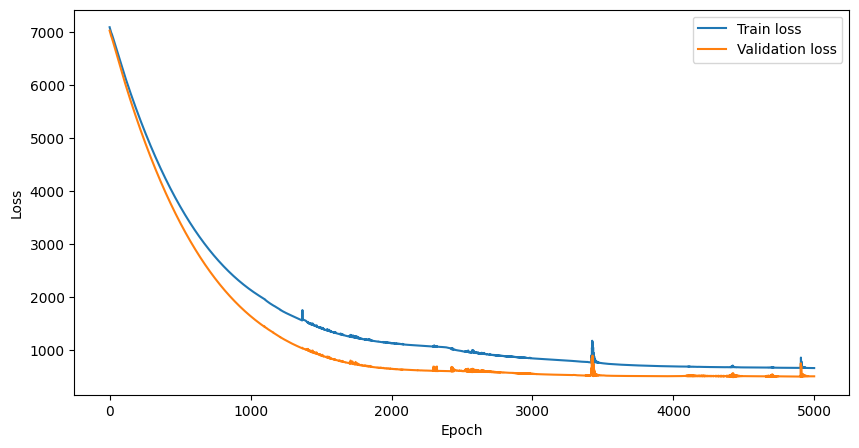

In [18]:
# model, loss function, and optimizer
input_size = 1
hidden_size = 5
output_size = 1

model = RNN(input_size, hidden_size, output_size)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.01)

# Train
num_epochs = 5000
train_losses = []
val_losses = []

for epoch in range(num_epochs):
    model.train()
    optimizer.zero_grad()
    outputs, hidden_states = model(train_sequences.view(-1, seq_len, 1))
    loss = criterion(outputs.view(-1, 1), train_labels.view(-1, 1))
    loss.backward()
    optimizer.step()
    train_losses.append(loss.item())

    model.eval()
    with torch.no_grad():
        val_outputs, hidden_states = model(val_sequences.view(-1, seq_len, 1))
        val_loss = criterion(val_outputs.view(-1, 1), val_labels.view(-1, 1))
        val_losses.append(val_loss.item())

    if epoch % 200 == 0:
        print(f'Epoch {epoch}/{num_epochs}, '
              f'Train loss: {loss.item():.2f}, '
              f'Validation loss: {val_loss.item():.2f}')

# test
model.eval()
with torch.no_grad():
    test_outputs, hidden_states = model(test_sequences.view(-1, seq_len, 1))
    test_loss = criterion(test_outputs.view(-1, 1), test_labels.view(-1, 1))
    print(f'Test loss: {test_loss.item():.2f}')

# Visualize the training progress
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Train loss')
plt.plot(val_losses, label='Validation loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [10]:
# Save the entire model
torch.save(model, 'rnn.pth')

# Later to load the model
model = torch.load('rnn.pth')
model.eval()

RNN(
  (rnn): RNN(1, 5, batch_first=True)
  (fc): Linear(in_features=5, out_features=1, bias=True)
)

In [11]:
model.eval()
with torch.no_grad():
    _, hidden_states = model(train_sequences.view(-1, seq_len, 1))
    _, h_test = model(test_sequences.view(-1, seq_len, 1))
    # h_states be shape (num_layers, batch_size, hidden_size)
    last_layer_states = hidden_states[-1]
    lls_test = h_test[-1]
    print(last_layer_states.shape)
    print(lls_test.shape)

torch.save(last_layer_states, 'rnn_h_train.pt')
torch.save(lls_test, 'rnn_h_test.pt')

torch.Size([597, 5])
torch.Size([199, 5])


In [16]:
def sliding_moving_average(data, window_size):
    if window_size >= len(data):
        raise ValueError("Window size must be less than the length of the data.")
    moving_averages = []
    for i in range(len(data) - window_size):
        window = data[i:i + window_size]
        moving_average = sum(window) / window_size
        moving_averages.append(moving_average)
    return moving_averages

# Test SMA algorithm on the dataset
window_size = 5
moving_averages = sliding_moving_average(Y, window_size)

# Calculate the MSE
mse = mean_squared_error(Y[window_size:], moving_averages)
print(f'Mean Squared Error: {mse}')

Mean Squared Error: 616.5721430765341
